In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, mpld3
from mpld3 import plugins
%matplotlib inline
#mpld3.enable_notebook()

import csv
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import date, timedelta
from scipy.fft import fft, ifft, fftfreq

# EDA

In [2]:
df = pd.read_csv('energy.dat')

In [3]:
df

,Date,Consumption
0,01-Apr-15,357.073
1,02-Apr-15,341.931
2,03-Apr-15,318.777
3,04-Apr-15,312.494
4,05-Apr-15,270.837
...,...,...
1822,27-Mar-20,237.171
1823,28-Mar-20,229.744
1824,29-Mar-20,297.636
1825,30-Mar-20,323.811


In [4]:
df.dtypes

Date            object
Consumption    float64
dtype: object

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.dtypes

Date           datetime64[ns]
Consumption           float64
dtype: object

In [7]:
df = df.rename(columns={'Date':'ds','Consumption':'y'})

In [8]:
df.shape

(1827, 2)

Text(0, 0.5, 'consumption')

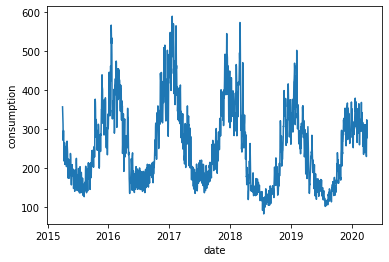

In [9]:
plt.figure()
plt.plot(df.ds, df.y)
plt.xlabel('date')
plt.ylabel('consumption')

In [12]:
df

,ds,y
0,2015-04-01,357.073
1,2015-04-02,341.931
2,2015-04-03,318.777
3,2015-04-04,312.494
4,2015-04-05,270.837
...,...,...
1822,2020-03-27,237.171
1823,2020-03-28,229.744
1824,2020-03-29,297.636
1825,2020-03-30,323.811


# Train, validation, test split

In [13]:
# constructing training, validation and test sets
def data_train_validate_test(df, training_set_percent=0.7, validation_set_percent=0.15, seed=None):
  length = len(df.index)  #size of index of dataset
  training_set_end = int(training_set_percent * length)  #size of the training set
  validation_set_end = int(validation_set_percent * length) + training_set_end  #size of the validation set + training set
  training = df.loc[:training_set_end] #select random rows up to the size of the training set to form the training dataset
  validation = df.loc[training_set_end+1:validation_set_end] #select random rows up to the size of validation set to form the validation dataset
  test = df.loc[validation_set_end+1:] #The remaining rows from the validation set onwards to the end will be the test dataset
  return training, validation, test

In [14]:
df_training, df_validation, df_test = data_train_validate_test(df)

In [16]:
df_training

,ds,y
0,2015-04-01,357.073
1,2015-04-02,341.931
2,2015-04-03,318.777
3,2015-04-04,312.494
4,2015-04-05,270.837
...,...,...
1274,2018-09-26,172.802
1275,2018-09-27,155.628
1276,2018-09-28,182.789
1277,2018-09-29,163.487


In [26]:
df_validation

,ds,y
1279,2018-10-01,201.030
1280,2018-10-02,226.232
1281,2018-10-03,207.030
1282,2018-10-04,180.827
1283,2018-10-05,160.632
...,...,...
1548,2019-06-27,169.050
1549,2019-06-28,170.858
1550,2019-06-29,151.068
1551,2019-06-30,143.059


# Facebook prophet model

In [10]:
m = Prophet()

In [11]:
m.fit(df)

13:10:27 - cmdstanpy - INFO - Chain [1] start processing
13:10:28 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = m.make_future_dataframe(periods=274)
future.tail()

,ds
2096,2020-12-26
2097,2020-12-27
2098,2020-12-28
2099,2020-12-29
2100,2020-12-30


In [13]:
future

,ds
0,2015-04-01
1,2015-04-02
2,2015-04-03
3,2015-04-04
4,2015-04-05
...,...
2096,2020-12-26
2097,2020-12-27
2098,2020-12-28
2099,2020-12-29


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2096,2020-12-26,263.534539,210.673012,314.842539
2097,2020-12-27,263.792696,209.686333,311.024517
2098,2020-12-28,294.196103,239.931025,347.740101
2099,2020-12-29,297.782827,244.398637,349.442034
2100,2020-12-30,298.863513,248.802797,349.627292


In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-01,266.280054,238.130599,338.680579,266.280054,266.280054,23.167903,23.167903,23.167903,9.460838,9.460838,9.460838,13.707065,13.707065,13.707065,0.0,0.0,0.0,289.447958
1,2015-04-02,266.288714,235.589081,340.672849,266.288714,266.288714,18.332561,18.332561,18.332561,8.339777,8.339777,8.339777,9.992784,9.992784,9.992784,0.0,0.0,0.0,284.621275
2,2015-04-03,266.297374,222.612299,327.820788,266.297374,266.297374,10.189487,10.189487,10.189487,3.863812,3.863812,3.863812,6.325675,6.325675,6.325675,0.0,0.0,0.0,276.486861
3,2015-04-04,266.306034,200.683901,301.043865,266.306034,266.306034,-17.413349,-17.413349,-17.413349,-20.140734,-20.140734,-20.140734,2.727385,2.727385,2.727385,0.0,0.0,0.0,248.892685
4,2015-04-05,266.314694,191.080946,297.955201,266.314694,266.314694,-21.389376,-21.389376,-21.389376,-20.609692,-20.609692,-20.609692,-0.779684,-0.779684,-0.779684,0.0,0.0,0.0,244.925318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2020-12-26,198.548311,210.673012,314.842539,188.354120,207.426887,64.986228,64.986228,64.986228,-20.140734,-20.140734,-20.140734,85.126962,85.126962,85.126962,0.0,0.0,0.0,263.534539
2097,2020-12-27,198.502494,209.686333,311.024517,188.234812,207.435845,65.290202,65.290202,65.290202,-20.609692,-20.609692,-20.609692,85.899894,85.899894,85.899894,0.0,0.0,0.0,263.792696
2098,2020-12-28,198.456677,239.931025,347.740101,188.138302,207.439986,95.739426,95.739426,95.739426,8.586701,8.586701,8.586701,87.152725,87.152725,87.152725,0.0,0.0,0.0,294.196103
2099,2020-12-29,198.410861,244.398637,349.442034,188.073994,207.439841,99.371966,99.371966,99.371966,10.499298,10.499298,10.499298,88.872668,88.872668,88.872668,0.0,0.0,0.0,297.782827


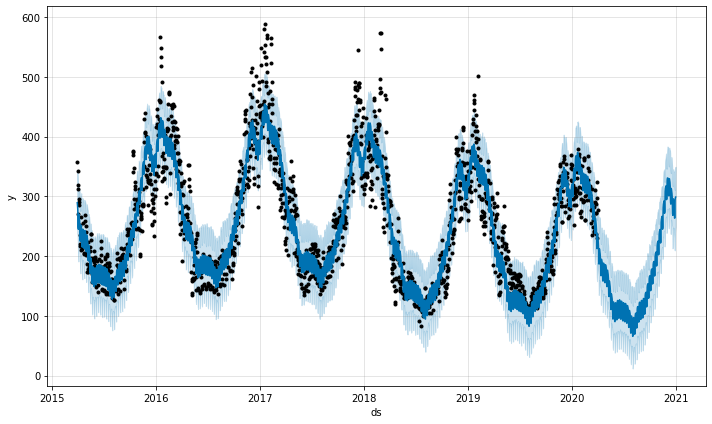

In [16]:
fig1 = m.plot(forecast)

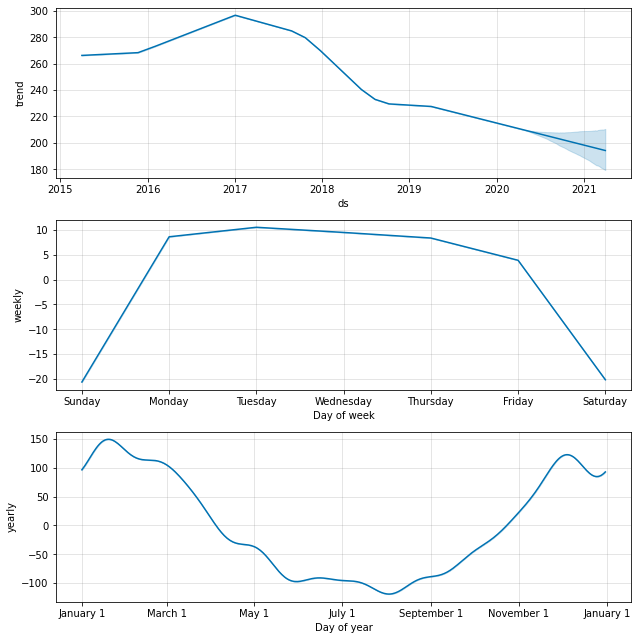

In [20]:
fig2 = m.plot_components(forecast)